In [19]:
#Imports & Setup

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

np.random.seed(42)

In [20]:
#Data Generation

X, y = make_blobs(
    n_samples=2000,
    centers=5,
    n_features=6,
    cluster_std=1.4,
    random_state=42
)

num_classes = 5
y_encoded = np.eye(num_classes)[y]

print("Feature Matrix :", X.shape)
print("One-hot Labels :", y_encoded.shape)


Feature Matrix : (2000, 6)
One-hot Labels : (2000, 5)


In [21]:
#Partitioning the dataset

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training :", X_train.shape, y_train.shape)
print("Testing  :", X_test.shape, y_test.shape)


Training : (1500, 6) (1500, 5)
Testing  : (500, 6) (500, 5)


In [22]:
#Utility Functions

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def softmax(z):
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_vals = np.exp(z_shifted)
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    eps = 1e-10
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))


In [23]:
#Fully Connected Neural Network

class DeepClassifier:
    def __init__(self, input_dim, h_units=(64, 32, 16), out_dim=5, lr=0.01):
        h1, h2, h3 = h_units
        self.lr = lr

        # Layer initializations
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, out_dim) * np.sqrt(2 / h3)
        self.b4 = np.zeros((1, out_dim))

    # Forward pass
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        self.out = softmax(self.Z4)

        return self.out

    # Backpropagation
    def backward(self, X, y):
        m = len(X)

        dZ4 = self.out - y
        dW4 = (self.A3.T @ dZ4) / m
        db4 = np.mean(dZ4, axis=0, keepdims=True)

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_grad(self.Z3)
        dW3 = (self.A2.T @ dZ3) / m
        db3 = np.mean(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_grad(self.Z2)
        dW2 = (self.A1.T @ dZ2) / m
        db2 = np.mean(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_grad(self.Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.mean(dZ1, axis=0, keepdims=True)

        # Gradient updates
        for W, b, dW, db in [
            (self.W1, self.b1, dW1, db1),
            (self.W2, self.b2, dW2, db2),
            (self.W3, self.b3, dW3, db3),
            (self.W4, self.b4, dW4, db4),
        ]:
            W -= self.lr * dW
            b -= self.lr * db

    # Training loop
    def fit(self, X, y, epochs=1000, verbose=200):
        losses = []
        for ep in range(epochs):
            predictions = self.forward(X)
            loss = cross_entropy(y, predictions)
            losses.append(loss)
            self.backward(X, y)

            if ep % verbose == 0:
                print(f"[{ep}/{epochs}] Loss = {loss:.4f}")

        return losses

    # Prediction
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1), probs


In [24]:
#Initialize Network & Train

model = DeepClassifier(
    input_dim=X_train.shape[1],
    h_units=(64, 32, 16),
    out_dim=num_classes,
    lr=0.01
)

EPOCHS = 1500
loss_track = model.fit(X_train, y_train, epochs=EPOCHS, verbose=100)


[0/1500] Loss = 6.6977
[100/1500] Loss = 0.0096
[200/1500] Loss = 0.0041
[300/1500] Loss = 0.0026
[400/1500] Loss = 0.0019
[500/1500] Loss = 0.0015
[600/1500] Loss = 0.0013
[700/1500] Loss = 0.0011
[800/1500] Loss = 0.0010
[900/1500] Loss = 0.0009
[1000/1500] Loss = 0.0008
[1100/1500] Loss = 0.0007
[1200/1500] Loss = 0.0007
[1300/1500] Loss = 0.0006
[1400/1500] Loss = 0.0006


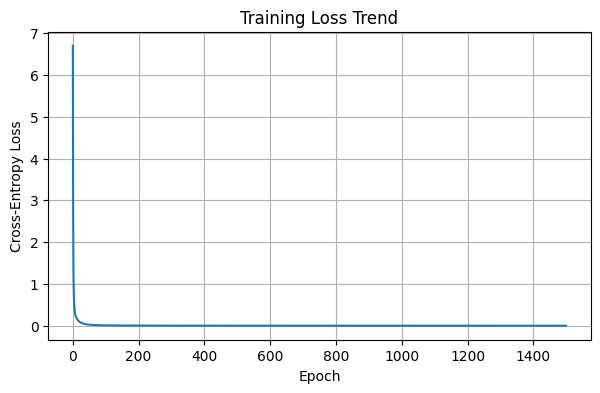

In [25]:
#Plot Training Loss Curve

plt.figure(figsize=(7, 4))
plt.plot(loss_track)
plt.title("Training Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()


In [26]:
#Evaluation on Test Set

y_pred_labels, prob_scores = model.predict(X_test)
true_labels = np.argmax(y_test, axis=1)

print("\n--- Performance Report ---")
print(classification_report(true_labels, y_pred_labels))



--- Performance Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



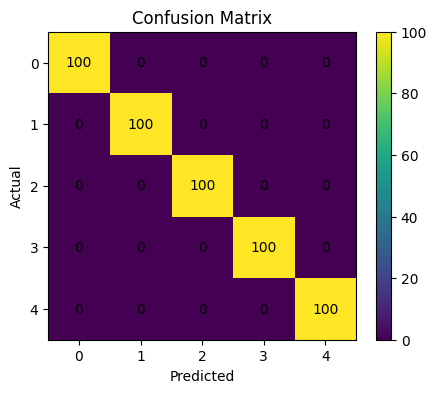

In [27]:
#Confusion Matrix


cm = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="viridis")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


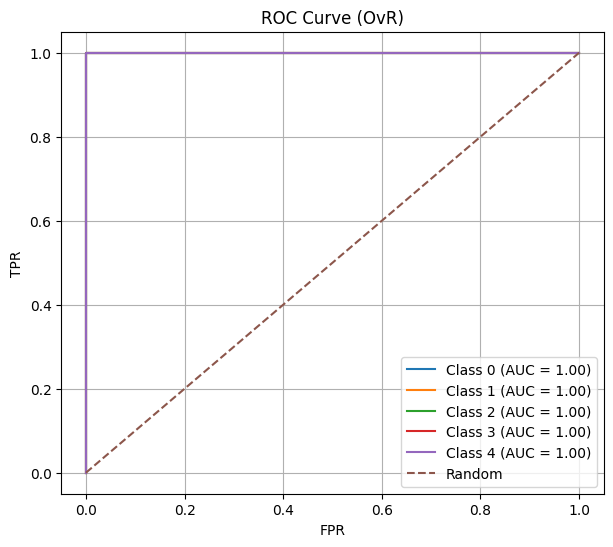

In [28]:
#ROC Curves for Each Class

y_bin = label_binarize(true_labels, classes=np.arange(num_classes))

plt.figure(figsize=(7, 6))

for c in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, c], prob_scores[:, c])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {c} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], '--', label="Random")
plt.title("ROC Curve (OvR)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
print("Model configuration:")
print("Input features:", input_dim)
print("Hidden layers: 64 -> 32 -> 16")
print("Output classes:", output_dim)
print("Learning rate:", model.lr)
print("Epochs trained:", epochs)

Model configuration:
Input features: 6
Hidden layers: 64 -> 32 -> 16
Output classes: 5
Learning rate: 0.01
Epochs trained: 1500
